In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
# 추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수

data['UserId'].nunique(), data['ItemId'].nunique()

# 유저의 숫자가 약 6천 개, 아이템 숫자는 약 4천 개가 됩니다.
# 이 수치가 유저의 수가 900만 명이라는 것은 아닙니다. 같은 유저가 여러 개의 세션을 만들 수도 있기 때문

(6040, 3706)

#### 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

#### Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

#### Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

#### 위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

# Step 1. 데이터의 전처리

### 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
### 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [5]:
# Session Length

In [6]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [8]:
user_length.min(), user_length.max()

(20, 2314)

In [9]:
user_length.quantile(0.999)

1343.181000000005

In [10]:
long_user = user_length[user_length==2314].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [11]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

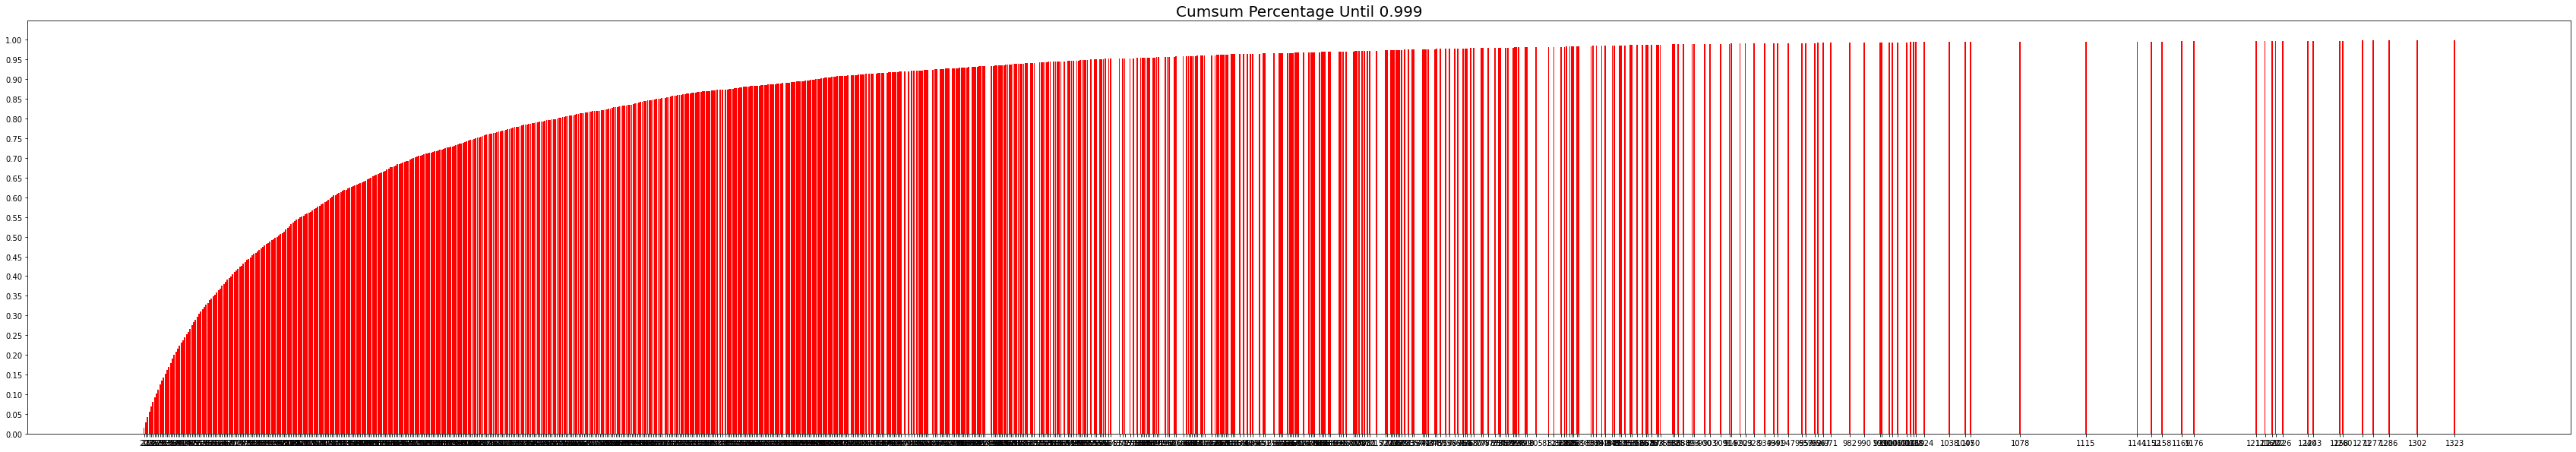

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(60, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [13]:
# Session time

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [15]:
type(latest)

numpy.int64

In [16]:
month_ago = latest - (86400*30)
#month_ago = latest - (86400*30) #최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time
28225,195,2808,3,1044220118
27759,195,1254,4,1044552222
27921,195,1456,2,1044662852
28443,195,468,3,1044985356
28255,195,2748,1,1044987808
...,...,...,...,...
984731,5950,3948,4,1046369637
984682,5950,3578,4,1046369670
984475,5950,3793,3,1046369710
984660,5950,3555,2,1046369737


In [17]:
aa = data.iloc[0,3]
aa

1044220118

In [18]:
data

,UserId,ItemId,Rating,Time
28225,195,2808,3,1044220118
27759,195,1254,4,1044552222
27921,195,1456,2,1044662852
28443,195,468,3,1044985356
28255,195,2748,1,1044987808
...,...,...,...,...
984731,5950,3948,4,1046369637
984682,5950,3578,4,1046369670
984475,5950,3793,3,1046369710
984660,5950,3555,2,1046369737


In [19]:
for i in range(len(data)):
    timestamp = data.iloc[i,3]
    datetimeobj = dt.datetime.fromtimestamp(timestamp/1000)
    data.iloc[i,3] = datetimeobj

In [20]:
type(data.iloc[0,3])

datetime.datetime

In [21]:
timestamp = data.iloc[0,3]
datetimeobj = dt.datetime.fromtimestamp(timestamp/1000)
datetimeobj

TypeError: unsupported operand type(s) for /: 'datetime.datetime' and 'int'

In [22]:
timestamp = 1463460958000 
datetimeobj = dt.datetime.fromtimestamp(timestamp/1000)
datetimeobj

datetime.datetime(2016, 5, 17, 4, 55, 58)

In [23]:
type(timestamp)

int

In [24]:
# Data Cleansing

In [25]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_user(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_user(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [26]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
58836,398,2028,4,1970-01-13 02:09:25.425000
58784,398,2762,5,1970-01-13 02:09:25.753000
58730,398,2628,3,1970-01-13 02:09:26.296000
58837,398,3697,2,1970-01-13 02:09:26.464000
58645,398,1196,4,1970-01-13 02:09:27.541000
62105,419,2424,4,1970-01-13 02:15:00.624000
62170,419,2028,5,1970-01-13 02:15:00.801000
62078,419,1196,5,1970-01-13 02:15:00.920000
62145,419,2762,5,1970-01-13 02:15:01.328000
62071,419,3793,4,1970-01-13 02:15:01.354000


In [27]:
# Train / Valid / Test split

In [28]:
test_path = data_path / 'ratings.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(956703932, 1046454590)

In [29]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = dt.datetime.fromtimestamp(data['Time'].max()/1000)
    user_last_time = data.groupby('UserId')['Time'].max()
    user_in_train = dt.datetime.fromtimestamp(user_last_time/1000)[dt.datetime.fromtimestamp(user_last_time/1000) < dt.datetime.fromtimestamp(final_time/1000) - dt.timedelta(n_days)].index
    user_in_test = dt.datetime.fromtimestamp(user_last_time/1000)[dt.datetime.fromtimestamp(user_last_time/1000) >= dt.datetime.fromtimestamp(final_time/1000) - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(user_in_train)]
    after_date = data[data['UserId'].isin(user_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [30]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

TypeError: unsupported operand type(s) for /: 'datetime.datetime' and 'int'

In [31]:
timestamp = 1463460958000 
datetimeobj = dt.datetime.fromtimestamp(timestamp/1000)
datetimeobj

datetime.datetime(2016, 5, 17, 4, 55, 58)

# Step 2. 미니 배치의 구성

### 실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
### 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

# Step 3. 모델 구성

### 이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

# Step 4. 모델 학습

### 다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

# Step 5. 모델 테스트

### 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.